In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

In [4]:
import itertools

In [6]:
df = pd.read_csv('processed_data.csv')

In [7]:
df.columns

Index(['id', 'backers_count', 'category', 'country', 'created_at', 'deadline',
       'is_starrable', 'launched_at', 'staff_pick', 'state', 'usd_pledged',
       'sub_category', 'creation_to_launch_days', 'campaign_days',
       'launch_day', 'deadline_day', 'launch_month', 'deadline_month',
       'launch_time', 'deadline_time', 'pledge_per_backer', 'usd_goal'],
      dtype='object')

In [8]:
df.shape

(198600, 22)

## Preparing target and features

In [9]:
# Dropping columns and creating new dataframe
df_transformed = df.drop(['backers_count', 'created_at', 'deadline', 'is_starrable', 
                          'launched_at', 'usd_pledged', 'sub_category', 'pledge_per_backer',
                         'launch_day', 'deadline_day', 'launch_month', 'deadline_month'], axis=1)
df_transformed.head()

,id,category,country,staff_pick,state,creation_to_launch_days,campaign_days,launch_time,deadline_time,usd_goal
0,2139821925,crafts,US,False,failed,1,30,4pm-6pm,4pm-6pm,1000.00
1,378093839,comics,US,True,successful,115,30,2pm-4pm,12am-2am,20000.00
2,1484057434,crafts,DE,True,successful,8,24,12am-2am,8pm-10pm,2847.66
3,1955625514,crafts,CA,False,successful,7,30,4pm-6pm,4pm-6pm,75.41
4,814342621,design,US,False,successful,777,40,2pm-4pm,2pm-4pm,7500.00


In [10]:
df_transformed['state'] = df_transformed['state'].replace({'failed': 0, 'successful': 1})

In [11]:
# Converting boolean features to string to include them in one-hot encoding
df_transformed['staff_pick'] = df_transformed['staff_pick'].astype(str)

In [12]:
# Creating dummy variables
df_transformed = pd.get_dummies(df_transformed, dummy_na=True)

In [13]:
y = df_transformed['state']

In [14]:
X_unscaled = df_transformed.drop('state', axis=1)

## Baseline Models

### logistic regression

In [15]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_unscaled), columns=list(X_unscaled.columns))
X.head()

,id,creation_to_launch_days,campaign_days,usd_goal,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,...,deadline_time_12pm-2pm,deadline_time_2am-4am,deadline_time_2pm-4pm,deadline_time_4am-6am,deadline_time_4pm-6pm,deadline_time_6am-8am,deadline_time_6pm-8pm,deadline_time_8am-10am,deadline_time_8pm-10pm,deadline_time_nan
0,1.721848,-0.347655,-0.223648,-0.033073,-0.342536,-0.215900,5.057943,-0.145405,-0.210427,-0.25385,...,-0.263424,-0.308699,-0.334479,-0.30817,2.633761,-0.247611,-0.358825,-0.185478,-0.346578,0.0
1,-1.123219,0.466121,-0.223648,-0.014499,-0.342536,4.631778,-0.197709,-0.145405,-0.210427,-0.25385,...,-0.263424,-0.308699,-0.334479,-0.30817,-0.379685,-0.247611,-0.358825,-0.185478,-0.346578,0.0
2,0.662834,-0.297686,-0.717947,-0.031267,-0.342536,-0.215900,5.057943,-0.145405,-0.210427,-0.25385,...,-0.263424,-0.308699,-0.334479,-0.30817,-0.379685,-0.247611,-0.358825,-0.185478,2.885352,0.0
3,1.424383,-0.304825,-0.223648,-0.033977,-0.342536,-0.215900,5.057943,-0.145405,-0.210427,-0.25385,...,-0.263424,-0.308699,-0.334479,-0.30817,2.633761,-0.247611,-0.358825,-0.185478,-0.346578,0.0
4,-0.418708,5.191734,0.600184,-0.026719,-0.342536,-0.215900,-0.197709,-0.145405,4.752252,-0.25385,...,-0.263424,-0.308699,2.989724,-0.30817,-0.379685,-0.247611,-0.358825,-0.185478,-0.346578,0.0


In [16]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [18]:
# Making predictions
y_hat_train = logreg.predict(X_train)
y_hat_logreg = logreg.predict(X_test)

In [19]:
# Logistic regression scores
print("Logistic regression score for test set:", round(logreg.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_hat_test))

Logistic regression score for test set: 0.72324

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.46      0.55     18244
           1       0.74      0.88      0.80     31406

    accuracy                           0.72     49650
   macro avg       0.71      0.67      0.67     49650
weighted avg       0.72      0.72      0.71     49650



In [20]:
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

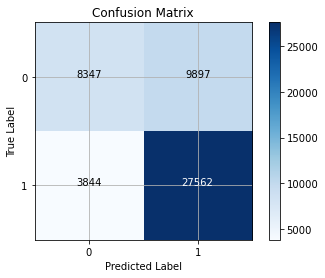

In [21]:
# Confusion matrix
plot_cf(y_test, y_hat_test)

In [22]:
# Your data
data = logreg.coef_
labels = X.columns

In [28]:
logreg.coef_.shape

(1, 74)

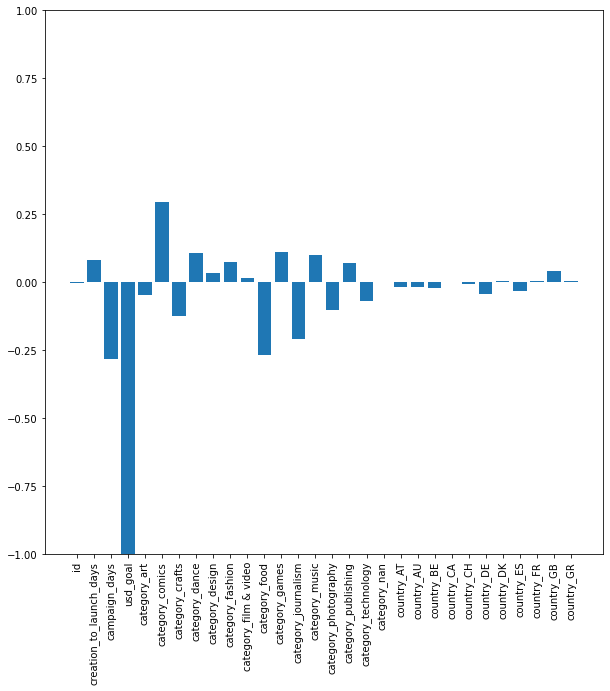

In [23]:
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(np.arange(30), data.ravel()[:30])
ax.set_xticks(np.arange(30))
ax.set_xticklabels(labels[:30], rotation=90)
ax.set_xticks(np.arange(30))
ax.set_ylim([-1,1]);
#high coefficients: usd goal, categories of comics, games, and music

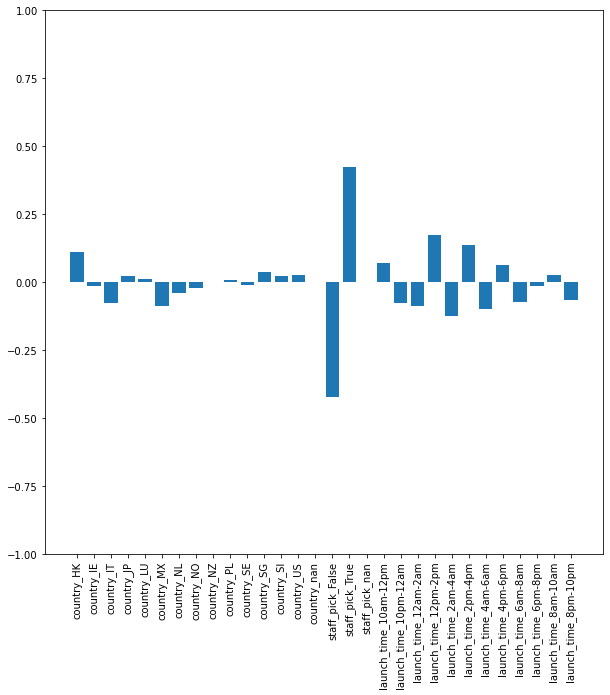

In [24]:
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(np.arange(30), data.ravel()[30:60])
ax.set_xticks(np.arange(30))
ax.set_xticklabels(labels[30:60], rotation=90)
ax.set_ylim([-1,1]);
#high coefficients: staff pick 0 or 1

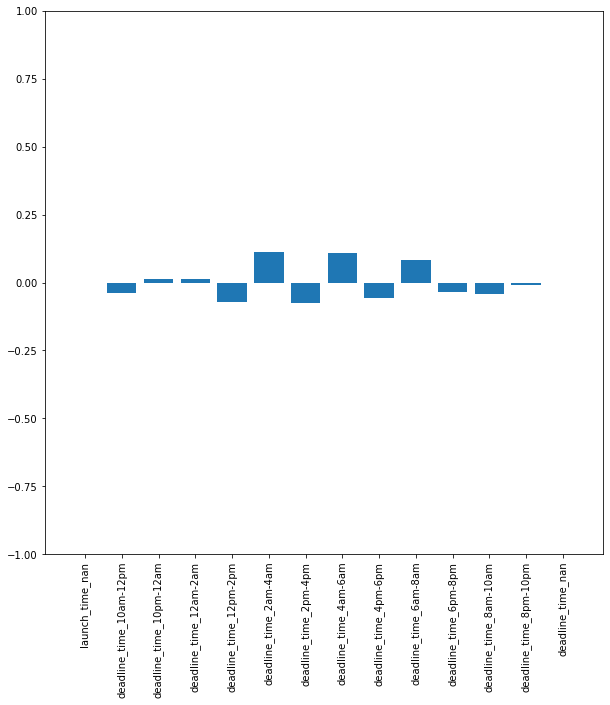

In [29]:
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(np.arange(14), data.ravel()[60:74])
ax.set_xticks(np.arange(14))
ax.set_xticklabels(labels[60:74], rotation=90)
ax.set_ylim([-1,1]);

### random forest

In [30]:
# Train and fit model                                                   
rf = RandomForestClassifier(random_state=1,n_jobs=-1)

rf.fit(X_train, y_train)
                                     
# Test Prediction
y_hat_rf = rf.predict(X_test)

# Printing evaluation metric (accuracy-score) 
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(f1_score(y_test, y_hat_rf, average = 'weighted')))

Accuracy score: 0.777
f1 score: 0.7705892761781368


In [31]:
print("Random Forest Classifier score for test set:", round(rf.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_hat_rf))

Random Forest Classifier score for test set: 0.77702

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.59      0.66     18244
           1       0.79      0.88      0.83     31406

    accuracy                           0.78     49650
   macro avg       0.77      0.74      0.75     49650
weighted avg       0.77      0.78      0.77     49650



In [32]:
rf.feature_importances_

array([1.70531430e-01, 1.62307638e-01, 9.78560897e-02, 2.18975249e-01,
       6.77672148e-03, 9.11745890e-03, 4.84572137e-03, 3.20669839e-03,
       4.52509942e-03, 4.63147859e-03, 7.38650654e-03, 1.56273187e-02,
       4.92164526e-03, 8.64458446e-03, 7.31068758e-03, 4.56842667e-03,
       5.68314858e-03, 7.28028825e-03, 0.00000000e+00, 9.61930656e-04,
       3.73614541e-03, 1.02853089e-03, 5.95477065e-03, 1.04424253e-03,
       3.53397533e-03, 1.32091969e-03, 2.64016513e-03, 3.01900726e-03,
       7.61733728e-03, 3.93599569e-05, 1.83993385e-03, 1.01306579e-03,
       2.91647418e-03, 9.07680243e-04, 1.13919301e-04, 3.49805337e-03,
       2.24129560e-03, 8.65458666e-04, 1.35385292e-03, 8.93041319e-05,
       2.00343669e-03, 1.08548511e-03, 1.81298504e-05, 1.19320313e-02,
       0.00000000e+00, 2.64037827e-02, 3.36573024e-02, 0.00000000e+00,
       4.16848098e-03, 6.21502699e-03, 5.57487317e-03, 5.14735324e-03,
       5.28301999e-03, 6.12499954e-03, 4.82568144e-03, 7.10183170e-03,
      

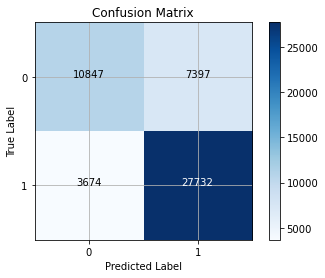

In [38]:
# Confusion matrix
plot_cf(y_test, y_hat_rf)

In [33]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:40], y=fi_df['feature_names'][:40])
    #Add chart labels
    plt.title(model_type + '', fontsize=20)
    plt.xlabel('Feature Importance', fontsize=13)
    plt.ylabel('Feature Names', fontsize=13)

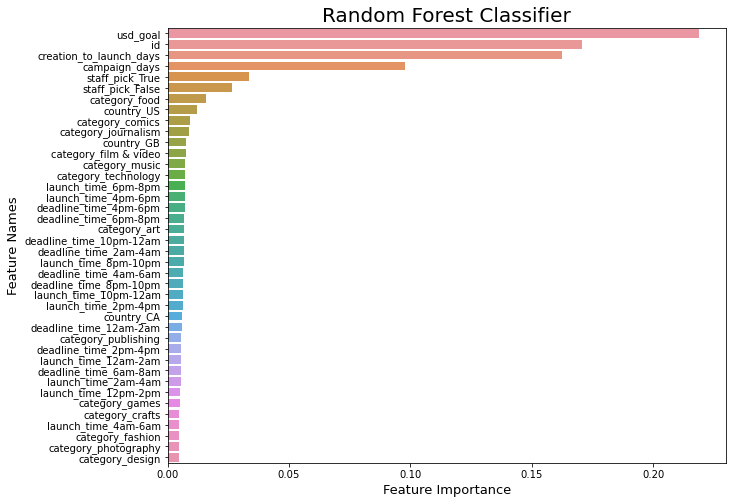

In [34]:
plot_feature_importance(rf.feature_importances_, X.columns,'Random Forest Classifier')

In [37]:
# Train and fit model                                                   
gb = GradientBoostingClassifier(random_state=1)

gb.fit(X_train, y_train)
                                     
# Test Prediction
y_hat_gb = rf.predict(X_test)

# Printing evaluation metric (accuracy-score) 
print('Accuracy score: {:.3}'.format(gb.score(X_test, y_test)))

# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(f1_score(y_test, y_hat_gb, average = 'weighted')))

Accuracy score: 0.758
f1 score: 0.7705892761781368


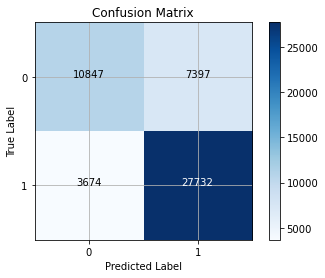

In [39]:
# Confusion matrix
plot_cf(y_test, y_hat_gb)